In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats

In [3]:
fifa = pd.read_csv('../data/EA_FIFA19.csv')

In [4]:
#Remove symbols and convert to nums for Wage,Value and Release Clause
def value_to_int(df_value):
    try:
        value = float(df_value[1:-1])
        suffix = df_value[-1:]

        if suffix == 'M':
            value = value * 1000000
        elif suffix == 'K':
            value = value * 1000
    except ValueError:
        value = 0
    return value

In [5]:
fifa['Value'] = fifa['Value'].apply(value_to_int)
fifa['Wage'] = fifa['Wage'].apply(value_to_int)

In [6]:
fifa['Release Clause'] = fifa['Release Clause'].fillna('0')
fifa['Release Clause'] = fifa['Release Clause'].apply(value_to_int)

In [7]:
def check_contract(row):
    month_list=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    ref_date = datetime(2018,5,31,0,0,0)
    contract = row['Contract Valid Until']
    try:
        match = re.findall('(\w{3}) \d{1,2}, (\d{4})',contract)
        if len(match)!=0:
            month_str = match[0][0]
            month = month_list.index(month_str)+1
            year = int(match[0][1])
            dt = datetime(year,month,1,0,0,0)
            a = dt- ref_date
            print(a)
            row['contract_days'] = a.days
        else:
            match = re.findall('(\d{4})',contract)
            month = month_list.index('Jun')+1
            year = int(match[0])
            dt = datetime(year,month,1,0,0,0)
            a = dt- ref_date
            row['contract_days'] = a.days
        return row
    except:
        year = 2020
        month = month_list.index('Jun')
        dt = datetime(year,month,1,0,0,0)
        a = dt- ref_date
        row['contract_days'] = a.days
        return row

In [8]:
#Turn Preferred Foot into a binary indicator variable
def right_footed(df):
    if (df['Preferred Foot'] == 'Right'):
        return 1
    else:
        return 0

#Create a simplified position varaible to account for all player positions
def simple_position(df):
    if (df['Position'] == 'GK'):
        return 'GK'
    elif ((df['Position'] == 'RB') | (df['Position'] == 'LB') | (df['Position'] == 'CB') | (df['Position'] == 'LCB') | (df['Position'] == 'RCB') | (df['Position'] == 'RWB') | (df['Position'] == 'LWB') ):
        return 'DF'
    elif ((df['Position'] == 'LDM') | (df['Position'] == 'CDM') | (df['Position'] == 'RDM')):
        return 'DM'
    elif ((df['Position'] == 'LM') | (df['Position'] == 'LCM') | (df['Position'] == 'CM') | (df['Position'] == 'RCM') | (df['Position'] == 'RM')):
        return 'MF'
    elif ((df['Position'] == 'LAM') | (df['Position'] == 'CAM') | (df['Position'] == 'RAM') | (df['Position'] == 'LW') | (df['Position'] == 'RW')):
        return 'AM'
    elif ((df['Position'] == 'RS') | (df['Position'] == 'ST') | (df['Position'] == 'LS') | (df['Position'] == 'CF') | (df['Position'] == 'LF') | (df['Position'] == 'RF')):
        return 'ST'
    else:
        return df.Position

#Get a count of Nationalities in the Dataset, make of list of those with over 250 Players (our Major Nations)
nat_counts = fifa.Nationality.value_counts()
nat_list = nat_counts[nat_counts > 250].index.tolist()

#Replace Nationality with a binary indicator variable for 'Major Nation'
def major_nation(df):
    if (df.Nationality in nat_list):
        return 1
    else:
        return 0



In [9]:
#Create a copy of the original dataframe to avoid indexing errors
df1 = fifa.copy()

#Apply changes to dataset to create new column
df1['Right_Foot'] = df1.apply(right_footed, axis=1)
df1['Simple_Position'] = df1.apply(simple_position,axis = 1)
df1['Major_Nation'] = df1.apply(major_nation,axis = 1)

#Split the Work Rate Column in two
tempwork = df1["Work Rate"].str.split("/ ", n = 1, expand = True) 
#Create new column for first work rate
df1["WorkRate1"]= tempwork[0]   
#Create new column for second work rate
df1["WorkRate2"]= tempwork[1]

In [10]:
adhoc = df1[['ID','Photo','Flag','Club Logo','Jersey Number','Joined','Special','Loaned From','Body Type', 'Release Clause',
               'Weight','Height','Contract Valid Until','Name','Club']]
#adhoc = adhoc.dropna()
adhoc.head()

,ID,Photo,Flag,Club Logo,Jersey Number,Joined,Special,Loaned From,Body Type,Release Clause,Weight,Height,Contract Valid Until,Name,Club
0,158023,https://cdn.sofifa.org/players/4/19/158023.png,https://cdn.sofifa.org/flags/52.png,https://cdn.sofifa.org/teams/2/light/241.png,10.0,"Jul 1, 2004",2202,NaN,Messi,226500000.0,159lbs,5'7,2021,L. Messi,FC Barcelona
1,20801,https://cdn.sofifa.org/players/4/19/20801.png,https://cdn.sofifa.org/flags/38.png,https://cdn.sofifa.org/teams/2/light/45.png,7.0,"Jul 10, 2018",2228,NaN,C. Ronaldo,127100000.0,183lbs,6'2,2022,Cristiano Ronaldo,Juventus
2,190871,https://cdn.sofifa.org/players/4/19/190871.png,https://cdn.sofifa.org/flags/54.png,https://cdn.sofifa.org/teams/2/light/73.png,10.0,"Aug 3, 2017",2143,NaN,Neymar,228100000.0,150lbs,5'9,2022,Neymar Jr,Paris Saint-Germain
3,193080,https://cdn.sofifa.org/players/4/19/193080.png,https://cdn.sofifa.org/flags/45.png,https://cdn.sofifa.org/teams/2/light/11.png,1.0,"Jul 1, 2011",1471,NaN,Lean,138600000.0,168lbs,6'4,2020,De Gea,Manchester United
4,192985,https://cdn.sofifa.org/players/4/19/192985.png,https://cdn.sofifa.org/flags/7.png,https://cdn.sofifa.org/teams/2/light/10.png,7.0,"Aug 30, 2015",2281,NaN,Normal,196400000.0,154lbs,5'11,2023,K. De Bruyne,Manchester City


In [11]:
df1.drop(columns=['ID','Photo','Flag','Club Logo','Jersey Number','Joined','Special','Loaned From','Body Type', 'Release Clause',
               'Weight','Height','Contract Valid Until','Name','Club'],inplace=True)

In [12]:
df1.columns

Index(['Age', 'Nationality', 'Overall', 'Potential', 'Value', 'Wage',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Real Face', 'Position', 'LS', 'ST', 'RS',
       'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM',
       'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB',
       'RCB', 'RB', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing',
       'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing',
       'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions',
       'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 'Right_Foot',
       'Simple_Position', 'Major_Nation', 'WorkRate1', 'WorkRate2'],
      dtype='object')

In [13]:
df1.drop(columns=['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB'],inplace=True)

In [14]:
df1.drop(['Work Rate','Preferred Foot','Real Face', 'Position','Nationality'], axis=1,inplace=True)

In [15]:
df2=pd.get_dummies(df1)

In [15]:
#Viz's for Eda
#Relation between age and Potential

sns.jointplot(x=fifa2['Age'],y=fifa2['Potential'],
              joint_kws={'alpha':0.1,'s':5,'color':'red'},
              marginal_kws={'color':'red'})



NameError: name 'fifa2' is not defined

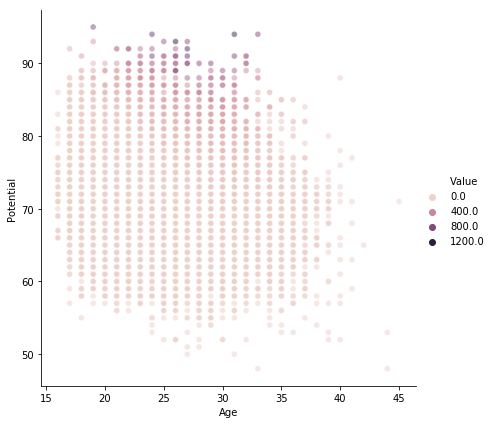

In [18]:
sns.relplot(x="Age", y="Potential", hue=fifa2['Value']/100000, 
            sizes=(40, 400), alpha=.5,
            height=6, data=fifa2);

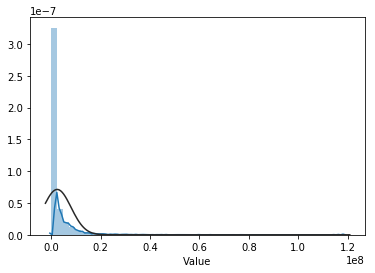

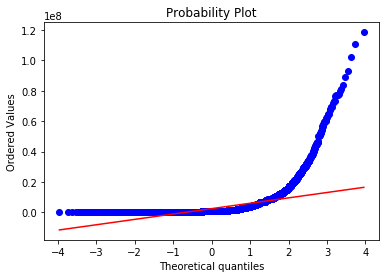

In [19]:
#Plot Player Value 
sns.distplot(fifa2['Value'], fit=norm);
fig = plt.figure()
res = stats.probplot(fifa2['Value'], plot=plt)

#Playr Value will have to log transformed for better results

C:\Users\arpan\Anaconda3\envs\football_manager\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


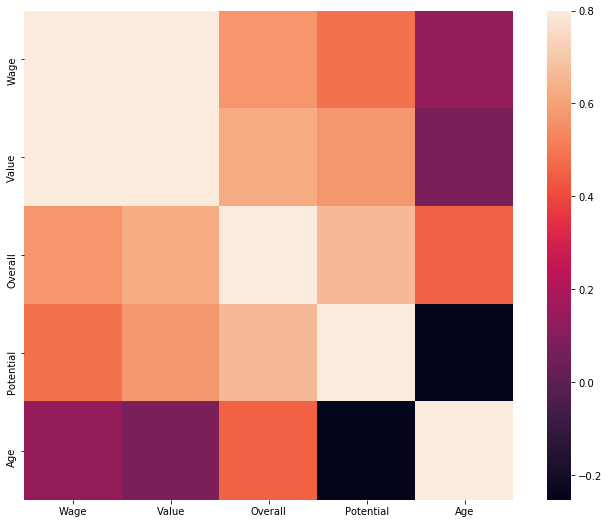

In [17]:
#Correlation
#correlation matrix

useful_features = ['Wage','Value','Overall','Potential','Age']
corrmat = fifa[useful_features].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.savefig('Corr.png')
f.show()

In [ ]:
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC




In [16]:
df2.columns

Index(['Age', 'Overall', 'Potential', 'Value', 'Wage',
       'International Reputation', 'Weak Foot', 'Skill Moves', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes', 'Right_Foot',
       'Major_Nation', 'Simple_Position_AM', 'Simple_Position_DF',
       'Simple_Position_DM', 'Simple_Position_GK', 'Simple_Position_MF',
       'Simple_Position_ST', 'WorkRate1_High', 'WorkRate1_Low',
       'WorkRate1_Medium', 'WorkRate2_High', 'WorkRate2_Low',
       'WorkRate2_Medium'],
      dtype='object')

In [17]:
df2['Wage'] = np.log10(df2['Wage']+1)
df2['Value'] = np.log10(df2['Value']+1) 

In [18]:
#Remove whose player values are 0
df3 = df2[df2['Value']!=0]
df3= df3[~df3['Agility'].isnull()]

In [19]:
#Ok niggas time to random forest

In [20]:
df3.columns

Index(['Age', 'Overall', 'Potential', 'Value', 'Wage',
       'International Reputation', 'Weak Foot', 'Skill Moves', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes', 'Right_Foot',
       'Major_Nation', 'Simple_Position_AM', 'Simple_Position_DF',
       'Simple_Position_DM', 'Simple_Position_GK', 'Simple_Position_MF',
       'Simple_Position_ST', 'WorkRate1_High', 'WorkRate1_Low',
       'WorkRate1_Medium', 'WorkRate2_High', 'WorkRate2_Low',
       'WorkRate2_Medium'],
      dtype='object')

In [21]:
labels = np.array(df3['Value'])
df3 = df3.drop(labels = ['Value','Wage','Overall'], axis=1)
features_list = ['Reactions','Potential','Age','BallControl','StandingTackle','Composure','Dribbling','Positioning',
                 'Finishing','GKReflexes']

features = np.array(df3[features_list])

In [22]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [23]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (13430, 10)
Training Labels Shape: (13430,)
Testing Features Shape: (4477, 10)
Testing Labels Shape: (4477,)


In [24]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 100 decision trees
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [25]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

# Print out the MSE
print('Mean Square Error:', round(np.sum(errors**2), 2))


Mean Absolute Error: 0.07
Mean Square Error: 37.73


In [26]:
from sklearn.metrics import r2_score

In [27]:
#Scale predicitions and labels to original values
pred_act = 10**predictions
test_act = 10**test_labels

r2_score(test_act, pred_act) 

0.9564217001322042

In [28]:
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(features_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Reactions            Importance: 0.4937
Variable: Potential            Importance: 0.3261
Variable: Age                  Importance: 0.0787
Variable: BallControl          Importance: 0.0449
Variable: StandingTackle       Importance: 0.0167
Variable: Composure            Importance: 0.0106
Variable: Positioning          Importance: 0.0086
Variable: Dribbling            Importance: 0.0082
Variable: Finishing            Importance: 0.0076
Variable: GKReflexes           Importance: 0.005


In [29]:
features = features_list
importances = rf.feature_importances_
indices = np.argsort(importances)



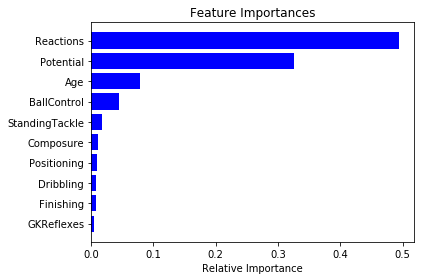

In [32]:
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.savefig('Var_Imp.png')

In [70]:
#Do knn 

In [93]:
knn_inp = {'Reactions':65,'Potential':80,'Age':25,'BallControl':79,'StandingTackle':80,'Composure':80,
 'Positionng':90,'Dribbling':65,'Finishing':80,'GKReflexes':90,'Position':'CAM'}

In [127]:
def knn_manip(knn_inp):
    df = pd.DataFrame(knn_inp,index=[0])
    df['Simple_Position'] = df.apply(simple_position,axis = 1)

    my_cols_list = ['Simple_Position_AM','Simple_Position_DF','Simple_Position_DM','Simple_Position_GK',
       'Simple_Position_MF','Simple_Position_ST']
    df = df.reindex(columns=[*df.columns.tolist(), *my_cols_list], fill_value=0)
    req_simp = df['Simple_Position'].values[0]
    col_name = 'Simple_Position_'+req_simp
    df[col_name]=1
    df.drop(labels=['Position','Simple_Position'],axis=1,inplace = True)
    
    #Find neighbors from processed data
    processed = pd.read_csv('../data/processed_fifa.csv')
    features_list = ['Reactions','Potential','Age','BallControl','StandingTackle','Composure','Positioning','Dribbling',
                 'Finishing','GKReflexes']+[col for col in processed.columns if col.startswith('Simple_')]
    position_data = processed.loc[processed[col_name]==1,:]
    y_train = position_data['Value']
    X_train = position_data[features_list]
    
    from sklearn.preprocessing import StandardScaler  
    scaler = StandardScaler()  
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    df = scaler.transform(df)
    
    regressor = KNeighborsRegressor(n_neighbors=5)  
    regressor.fit(X_train, y_train) 
    nneighbors = position_data.iloc[regressor.kneighbors(df)[1][0],:]
    nneighbor_id = nneighbors['ID'].tolist()
    return nneighbor_id

In [128]:
out = knn_manip(knn_inp)

C:\Users\arpan\Anaconda3\envs\football_manager\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\arpan\Anaconda3\envs\football_manager\lib\site-packages\ipykernel_launcher.py:24: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
C:\Users\arpan\Anaconda3\envs\football_manager\lib\site-packages\ipykernel_launcher.py:25: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


In [129]:
out

[185165, 230272, 192255, 230273, 234025]

In [130]:
chk = processed.loc[processed['ID'].isin(out),:]

In [18]:
import os

In [25]:
os.environ.get('MY_SQL_USER')


'root'

In [22]:
os.environ

environ{'ALLUSERSPROFILE': 'C:\\ProgramData',
        'APPDATA': 'C:\\Users\\arpan\\AppData\\Roaming',
        'COMMONPROGRAMFILES': 'C:\\Program Files\\Common Files',
        'COMMONPROGRAMFILES(X86)': 'C:\\Program Files (x86)\\Common Files',
        'COMMONPROGRAMW6432': 'C:\\Program Files\\Common Files',
        'COMPUTERNAME': 'DESKTOP-NR2TU7G',
        'COMSPEC': 'C:\\Windows\\system32\\cmd.exe',
        'CONDA_BAT': 'C:\\Users\\arpan\\Anaconda3\\condabin\\conda.bat',
        'CONDA_DEFAULT_ENV': 'football_manager',
        'CONDA_EXE': 'C:\\Users\\arpan\\Anaconda3\\Scripts\\conda.exe',
        'CONDA_PREFIX': 'C:\\Users\\arpan\\Anaconda3\\envs\\football_manager',
        'CONDA_PROMPT_MODIFIER': '(football_manager) ',
        'CONDA_PYTHON_EXE': 'C:\\Users\\arpan\\Anaconda3\\python.exe',
        'CONDA_SHLVL': '1',
        'DRIVERDATA': 'C:\\Windows\\System32\\Drivers\\DriverData',
        'FPS_BROWSER_APP_PROFILE_STRING': 'Internet Explorer',
        'FPS_BROWSER_USER_PROFILE_ST

In [24]:
os.environ['MY_SQL_USER'] = 'root'

In [26]:
os.environ['MY_SQL_PASSWORD'] = 'TQuNTU9emjMJmi7'